In [1]:
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import transformers
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import re
from catboost import CatBoostRegressor, cv, Pool
from tqdm import notebook

import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /home/user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


Посмотрим сначала на train

In [2]:
train_dataset = pd.read_csv('train_dataset.csv')
train_dataset

image                     query_id  \
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1     1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2     2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4     2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   
...                         ...                          ...   
5817   757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5818   799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819   909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820   929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821   968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                             query_text  
0     A young child is wearing blue goggles and sitt...  
1     A young child is wearing blue goggles and sitt...  
2     A young child is wearing blue goggles and sitt...  
3     A young child is wearing blue goggles and sitt...  
4     A young child is wearing blue goggles and sitt...  
...                                                 ...  
5817         A man in an ampitheater talking to a boy .  
5818          a old man walks down the uncrowded road .  
5819       A dog stands on the side of a grassy cliff .  
5820                       A blurry photo of two dogs .  
5821                        A man rows his boat below .  

[5822 rows x 3 columns]

In [3]:
ExpertAnnotations = pd.read_csv('ExpertAnnotations.tsv', sep='\t',
                                   names=['file_name', 'query_id', 'frst', 'scnd', 'thd'])
ExpertAnnotations

file_name                     query_id  frst  scnd  thd
0     1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1    1
1     1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     1     1    2
2     1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1     1    2
3     1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2     1     2    2
4     1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2     1     1    2
...                         ...                          ...   ...   ...  ...
5817   997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2     1     1    1
5818   997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2     1     1    1
5819   997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2     1     1    2
5820   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2     1     1    1
5821   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     3     3    3

[5822 rows x 5 columns]

In [4]:
CrowdAnnotations = pd.read_csv('CrowdAnnotations.tsv', sep='\t',
                               names=['file_name', 'query_id', 'rate', 'pos', 'neg'])
CrowdAnnotations

file_name                     query_id      rate  pos  \
0      1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.000000    3   
1      1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.000000    0   
2      1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  0.000000    0   
3      1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  0.000000    0   
4      1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  0.000000    0   
...                          ...                          ...       ...  ...   
47825   997722733_0cb5439472.jpg   543007912_23fc735b99.jpg#2  0.000000    0   
47826   997722733_0cb5439472.jpg   544576742_283b65fa0d.jpg#2  0.333333    1   
47827   997722733_0cb5439472.jpg   872622575_ba1d3632cc.jpg#2  1.000000    3   
47828   997722733_0cb5439472.jpg   888425986_e4b6c12324.jpg#2  0.000000    0   
47829   997722733_0cb5439472.jpg   997722733_0cb5439472.jpg#2  0.666667    2   

       neg  
0        0  
1        3  
2        3  
3        3  
4        3  
...    ...  
47825    3  
47826    2  
47827    0  
47828    3  
47829    1  

[47830 rows x 5 columns]

Сразу от меня вопрос: зачем нам данные по соответствию изображения и описания, полученные с помощью краудсорсинга, если у нас есть у нас есть данные по соответствию изображения и описания, полученные в результате опроса экспертов?

И у нас получается длина train_dataset и ExpertAnnotations = 5822, а CrowdAnnotations = 47830!

Cмотрим на test

In [5]:
test_queries = pd.read_csv('test_queries.csv', index_col=[0], sep='|')
test_queries

query_id  \
0    1177994172_10d143cb8d.jpg#0   
1    1177994172_10d143cb8d.jpg#1   
2    1177994172_10d143cb8d.jpg#2   
3    1177994172_10d143cb8d.jpg#3   
4    1177994172_10d143cb8d.jpg#4   
..                           ...   
495   989851184_9ef368e520.jpg#0   
496   989851184_9ef368e520.jpg#1   
497   989851184_9ef368e520.jpg#2   
498   989851184_9ef368e520.jpg#3   
499   989851184_9ef368e520.jpg#4   

                                            query_text  \
0    Two blonde boys , one in a camouflage shirt an...   
1    Two boys are squirting water guns at each other .   
2              Two boys spraying each other with water   
3    Two children wearing jeans squirt water at eac...   
4    Two young boys are squirting water at each oth...   
..                                                 ...   
495          A black dog has a dumbbell in his mouth .   
496  A black dog has a dumbbell in his mouth lookin...   
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                         image  
0    1177994172_10d143cb8d.jpg  
1    1177994172_10d143cb8d.jpg  
2    1177994172_10d143cb8d.jpg  
3    1177994172_10d143cb8d.jpg  
4    1177994172_10d143cb8d.jpg  
..                         ...  
495   989851184_9ef368e520.jpg  
496   989851184_9ef368e520.jpg  
497   989851184_9ef368e520.jpg  
498   989851184_9ef368e520.jpg  
499   989851184_9ef368e520.jpg  

[500 rows x 3 columns]

У нас получается еще такой момент: имя изображеня вроде бы одно 1177994172_10d143cb8d.jpg, но к нему есть разные запросы. и поэтому в query_id к нему стоит еще номер, если я правильно понимаю

In [6]:
test_images = pd.read_csv('test_images.csv', index_col=[0], sep='|')
test_images

Empty DataFrame
Columns: []
Index: [3356748019_2251399314.jpg, 2887171449_f54a2b9f39.jpg, 3089107423_81a24eaf18.jpg, 1429546659_44cb09cbe2.jpg, 1177994172_10d143cb8d.jpg, 424307754_1e2f44d265.jpg, 3044359043_627488ddf0.jpg, 3396275223_ee080df8b5.jpg, 2977379863_2e8d7a104e.jpg, 634891010_9fa189effb.jpg, 3555573680_41c1540a86.jpg, 2060031241_a3ae7a06bb.jpg, 2885891981_6b02620ae9.jpg, 3438981089_2ef1a6353c.jpg, 661749711_6f408dad62.jpg, 1468389504_c724bdcad0.jpg, 989851184_9ef368e520.jpg, 2505465055_f1e6cf9b76.jpg, 123997871_6a9ca987b1.jpg, 3653484549_f316590b0f.jpg, 3488087117_2719647989.jpg, 3330333217_1a69497a74.jpg, 862156271_3eacea90a8.jpg, 2428094795_d3a8f46046.jpg, 3421547427_53411b6278.jpg, 3722572342_6904d11d52.jpg, 989754491_7e53fb4586.jpg, 3287969199_08e775d896.jpg, 2201192417_d934730fea.jpg, 345785626_9fa59f38ce.jpg, 3393035454_2d2370ffd4.jpg, 2107838729_a527e434bd.jpg, 3030079705_0dee8a3e89.jpg, 186346360_541047336f.jpg, 2597308074_acacc12e1b.jpg, 3033612929_764d977bd5.jpg, 3487131146_9d3aca387a.jpg, 440190907_bf8b7ba8ef.jpg, 3455405300_aa3069ecaa.jpg, 381514859_b40418d9c3.jpg, 3466891862_9afde75568.jpg, 572618443_647483ca82.jpg, 3520936130_9e90872560.jpg, 3459871361_92d1ecda36.jpg, 3184031654_34b5c4ffe1.jpg, 2517284816_9b8fd3c6b6.jpg, 3351418768_596ef7fd6f.jpg, 2709359730_13bca100af.jpg, 2308256827_3c0a7d514d.jpg, 3517023411_a8fbd15230.jpg, 2399551242_c62a46dd5f.jpg, 3154152744_4e93ec8a62.jpg, 2141713971_e25eb12712.jpg, 3553476195_fb3747d7c1.jpg, 2714674623_8cd05ac114.jpg, 3211199368_ca78387f72.jpg, 782401952_5bc5d3413a.jpg, 3247693965_845b3b4349.jpg, 3435015880_eda46ff50f.jpg, 3044745642_1d0784ff29.jpg, 3173157541_70b16b4318.jpg, 3690425778_3b390b3ea5.jpg, 3119913014_688d4997d7.jpg, 191003283_992257f835.jpg, 3163198309_bbfe504f0a.jpg, 3122579598_14841c038a.jpg, 1319634306_816f21677f.jpg, 3482859574_3908de3427.jpg, 957682378_46c3b07bcd.jpg, 2448210587_9fe7ea5f42.jpg, 1580671272_3e99d94305.jpg, 607339469_af851c4119.jpg, 269650644_059a84ece5.jpg, 2737233999_34d60dc5c3.jpg, 3170110692_d1e0e66cee.jpg, 3601978895_9fec23ce0c.jpg, 2461990494_c5ece064cc.jpg, 973827791_467d83986e.jpg, 3142055158_01b9e4caa4.jpg, 1232148178_4f45cc3284.jpg, 1991806812_065f747689.jpg, 3514297698_0512623955.jpg, 2986716822_e220754d32.jpg, 2505056124_1276e8dbcb.jpg, 2121140070_a09644550b.jpg, 3398788809_25c71ba018.jpg, 1745110280_0cbff5e273.jpg, 2552438538_285a05b86c.jpg, 3262849619_0bc4f88ef9.jpg, 2687672606_275169c35d.jpg, 3386953179_84c2d7922f.jpg, 3036971334_78187a9570.jpg, 404850242_3a55a4c874.jpg, 3730011701_5352e02286.jpg, 862177617_c2c0581075.jpg, 2431120202_b24fe2333a.jpg, 2399219552_bbba0a9a59.jpg, 3091962081_194f2f3bd4.jpg, 2670637584_d96efb8afa.jpg, 2346402952_e47d0065b6.jpg]

[100 rows x 0 columns]

Посмотрим явные дубликаты

In [7]:
train_dataset.duplicated().sum() , ExpertAnnotations.duplicated().sum() , CrowdAnnotations.duplicated().sum()

(0, 0, 0)

In [8]:
test_queries.duplicated().sum() , test_images.duplicated().sum()

(0, 0)

Явных дубликатов нет

Посмотрим на первые 5 изображений

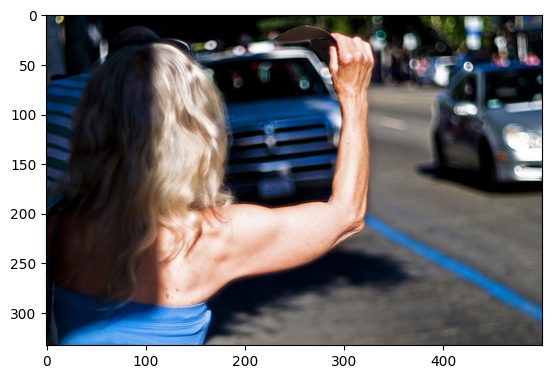

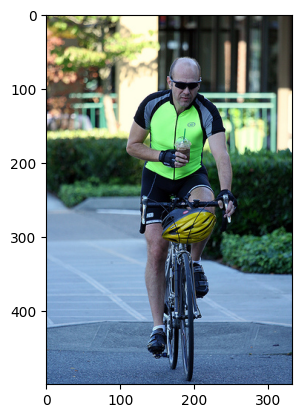

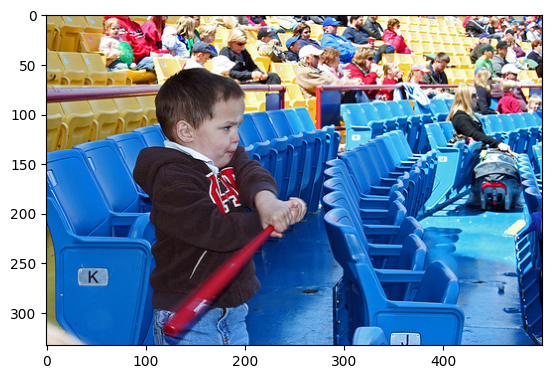

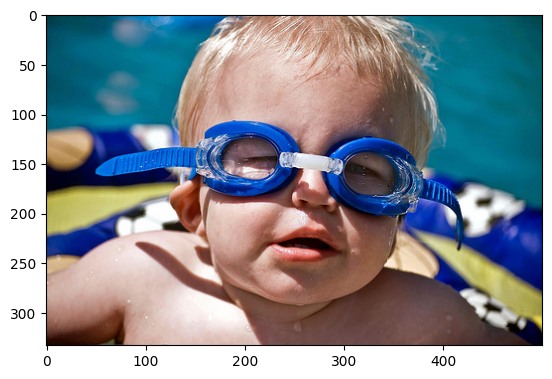

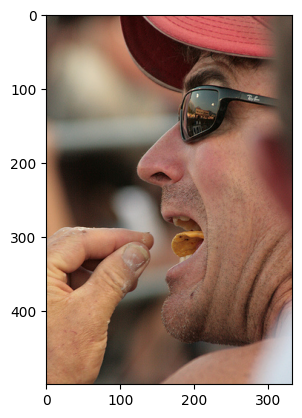

In [9]:
images = list(train_dataset['image'][:5])

for img in images:
        
    img=cv2.imread('./train_images/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)
    # plt.title('my picture')
    plt.show()

## 1. Агрегация оценок

In [10]:
ExpertAnnotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  5822 non-null   object
 1   query_id   5822 non-null   object
 2   frst       5822 non-null   int64 
 3   scnd       5822 non-null   int64 
 4   thd        5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [11]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


Объеденим для удобства ExpertAnnotations и train_dataset

In [12]:
train = pd.merge(ExpertAnnotations, train_dataset, how='inner', on=['query_id'])
train

file_name                     query_id  frst  scnd  \
0      1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
1      1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
2      1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
3      1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
4      1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
...                          ...                          ...   ...   ...   
50877   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2     1     1   
50878   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2     1     1   
50879   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     3     3   
50880   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     3     3   
50881   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     3     3   

       thd                      image  \
0        1  1056338697_4f7d7ce270.jpg   
1        1  1262583859_653f1469a9.jpg   
2        1  2447284966_d6bbdb4b6e.jpg   
3        1  2549968784_39bfbe44f9.jpg   
4        1  2621415349_ef1a7e73be.jpg   
...    ...                        ...   
50877    1    70995350_75d0698839.jpg   
50878    1   997722733_0cb5439472.jpg   
50879    3  1387785218_cee67735f5.jpg   
50880    3  3449114979_6cdc3e8da8.jpg   
50881    3   997722733_0cb5439472.jpg   

                                              query_text  
0      A young child is wearing blue goggles and sitt...  
1      A young child is wearing blue goggles and sitt...  
2      A young child is wearing blue goggles and sitt...  
3      A young child is wearing blue goggles and sitt...  
4      A young child is wearing blue goggles and sitt...  
...                                                  ...  
50877         A white birds lands swiftly in the water .  
50878         A white birds lands swiftly in the water .  
50879       A person wearing a white hat climbs a rock .  
50880       A person wearing a white hat climbs a rock .  
50881       A person wearing a white hat climbs a rock .  

[50882 rows x 7 columns]

У нас получилось 50к строк, насколько я понимаю это происходит потому что у нас к одной картинке может быть несколько описаний

По поводу агрегации оценок я сделаю очень просто - возму среднюю по трем и пронормирую в диапазон [0:1]

In [13]:
train[['frst', 'scnd','thd']].sum(axis = 1) / train[['frst', 'scnd','thd']].sum(axis = 1).max()

0        0.25
1        0.25
2        0.25
3        0.25
4        0.25
         ... 
50877    0.25
50878    0.25
50879    0.75
50880    0.75
50881    0.75
Length: 50882, dtype: float64

In [14]:
train['target'] = train[['frst', 'scnd','thd']].sum(axis = 1) / train[['frst', 'scnd','thd']].sum(axis = 1).max()

In [15]:
train

file_name                     query_id  frst  scnd  \
0      1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
1      1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
2      1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
3      1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
4      1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
...                          ...                          ...   ...   ...   
50877   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2     1     1   
50878   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2     1     1   
50879   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     3     3   
50880   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     3     3   
50881   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     3     3   

       thd                      image  \
0        1  1056338697_4f7d7ce270.jpg   
1        1  1262583859_653f1469a9.jpg   
2        1  2447284966_d6bbdb4b6e.jpg   
3        1  2549968784_39bfbe44f9.jpg   
4        1  2621415349_ef1a7e73be.jpg   
...    ...                        ...   
50877    1    70995350_75d0698839.jpg   
50878    1   997722733_0cb5439472.jpg   
50879    3  1387785218_cee67735f5.jpg   
50880    3  3449114979_6cdc3e8da8.jpg   
50881    3   997722733_0cb5439472.jpg   

                                              query_text  target  
0      A young child is wearing blue goggles and sitt...    0.25  
1      A young child is wearing blue goggles and sitt...    0.25  
2      A young child is wearing blue goggles and sitt...    0.25  
3      A young child is wearing blue goggles and sitt...    0.25  
4      A young child is wearing blue goggles and sitt...    0.25  
...                                                  ...     ...  
50877         A white birds lands swiftly in the water .    0.25  
50878         A white birds lands swiftly in the water .    0.25  
50879       A person wearing a white hat climbs a rock .    0.75  
50880       A person wearing a white hat climbs a rock .    0.75  
50881       A person wearing a white hat climbs a rock .    0.75  

[50882 rows x 8 columns]

заодно посмотрим распределение итоговых оценок

<Axes: >

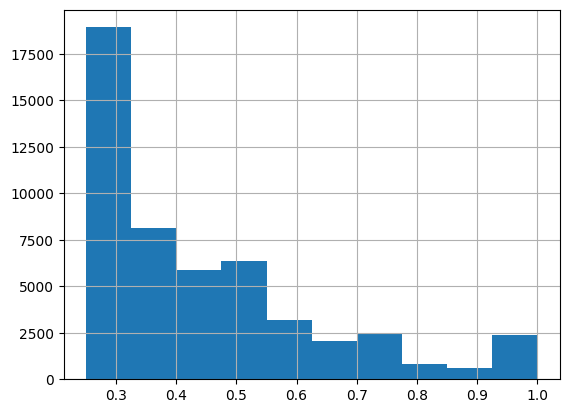

In [16]:
train['target'].hist()

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Я посмотрел тестовые изображения в папке, там тоже есть изображения с детьми. Обычно тестовую выборку не чистят от выбросов и т.п., чтобы модель проверить на более приближенных к реальности данных. Я не буду чистить тестовую выборку

In [17]:
lemmatize = nltk.WordNetLemmatizer()

In [18]:
train

file_name                     query_id  frst  scnd  \
0      1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
1      1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
2      1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
3      1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
4      1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1   
...                          ...                          ...   ...   ...   
50877   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2     1     1   
50878   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2     1     1   
50879   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     3     3   
50880   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     3     3   
50881   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     3     3   

       thd                      image  \
0        1  1056338697_4f7d7ce270.jpg   
1        1  1262583859_653f1469a9.jpg   
2        1  2447284966_d6bbdb4b6e.jpg   
3        1  2549968784_39bfbe44f9.jpg   
4        1  2621415349_ef1a7e73be.jpg   
...    ...                        ...   
50877    1    70995350_75d0698839.jpg   
50878    1   997722733_0cb5439472.jpg   
50879    3  1387785218_cee67735f5.jpg   
50880    3  3449114979_6cdc3e8da8.jpg   
50881    3   997722733_0cb5439472.jpg   

                                              query_text  target  
0      A young child is wearing blue goggles and sitt...    0.25  
1      A young child is wearing blue goggles and sitt...    0.25  
2      A young child is wearing blue goggles and sitt...    0.25  
3      A young child is wearing blue goggles and sitt...    0.25  
4      A young child is wearing blue goggles and sitt...    0.25  
...                                                  ...     ...  
50877         A white birds lands swiftly in the water .    0.25  
50878         A white birds lands swiftly in the water .    0.25  
50879       A person wearing a white hat climbs a rock .    0.75  
50880       A person wearing a white hat climbs a rock .    0.75  
50881       A person wearing a white hat climbs a rock .    0.75  

[50882 rows x 8 columns]

In [19]:
# слова, по которым отбираем фотки с детьми
worlds = ['teenager', 'girl', 'teenage', 'child',  'boy', 'kid']

In [20]:
# Функция возвращает не неудовлетворяющий запрос, а изображение к неудовлетворяющему запросу, т.к. изображению имеем много запросов
def bad_queries(df):
    eee = re.sub('[^a-zA-Z]', ' ', df['query_text']).lower()
    eee = nltk.word_tokenize(eee)
    eee = [lemmatize.lemmatize(com) for com in eee]

    if any(item in worlds for item in eee):
        return df['query_id'][:-2]

In [21]:
# неудовлетворяющие изображения, 274 штук
bad_queries_id = train.apply(bad_queries, axis = 1).dropna().drop_duplicates()
bad_queries_id

0        2549968784_39bfbe44f9.jpg
12       2718495608_d8533e3ac5.jpg
44       3545652636_0746537307.jpg
82       1714316707_8bbaa2a2ba.jpg
84       2140182410_8e2a06fbda.jpg
                   ...            
44572     909191414_1cf5d85821.jpg
45496     523985664_c866af4850.jpg
45736    1352410176_af6b139734.jpg
49630    2475162978_2c51048dca.jpg
49763    2061144717_5b3a1864f0.jpg
Length: 274, dtype: object

In [22]:
# здесь отбросим 2 последних знака для удобства
train['query_id0'] = train['query_id'].apply(lambda x: x[:-2])
train[['query_id0', 'query_id']]

query_id0                     query_id
0      2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2
1      2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2
2      2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2
3      2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2
4      2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2
...                          ...                          ...
50877  3375070563_3c290a7991.jpg  3375070563_3c290a7991.jpg#2
50878  3375070563_3c290a7991.jpg  3375070563_3c290a7991.jpg#2
50879   486917990_72bd4069af.jpg   486917990_72bd4069af.jpg#2
50880   486917990_72bd4069af.jpg   486917990_72bd4069af.jpg#2
50881   486917990_72bd4069af.jpg   486917990_72bd4069af.jpg#2

[50882 rows x 2 columns]

In [23]:
# аккуратненько отбросим строки с неудовлетворяющими изображениями, количество строк уменьшилось
train = train[~train['query_id0'].isin(bad_queries_id)].reset_index()

train

index                  file_name                     query_id  frst  \
0         22  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1   
1         23  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1   
2         24  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1   
3         25  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1   
4         26  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1   
...      ...                        ...                          ...   ...   
39579  50877   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2     1   
39580  50878   997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2     1   
39581  50879   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     3   
39582  50880   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     3   
39583  50881   997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2     3   

       scnd  thd                      image  \
0         1    2  1056338697_4f7d7ce270.jpg   
1         1    2  3187395715_f2940c2b72.jpg   
2         1    2   463978865_c87c6ca84c.jpg   
3         1    2   488590040_35a3e96c89.jpg   
4         1    2   534875358_6ea30d3091.jpg   
...     ...  ...                        ...   
39579     1    1    70995350_75d0698839.jpg   
39580     1    1   997722733_0cb5439472.jpg   
39581     3    3  1387785218_cee67735f5.jpg   
39582     3    3  3449114979_6cdc3e8da8.jpg   
39583     3    3   997722733_0cb5439472.jpg   

                                            query_text    target  \
0      A man sleeps under a blanket on a city street .  0.333333   
1      A man sleeps under a blanket on a city street .  0.333333   
2      A man sleeps under a blanket on a city street .  0.333333   
3      A man sleeps under a blanket on a city street .  0.333333   
4      A man sleeps under a blanket on a city street .  0.333333   
...                                                ...       ...   
39579       A white birds lands swiftly in the water .  0.250000   
39580       A white birds lands swiftly in the water .  0.250000   
39581     A person wearing a white hat climbs a rock .  0.750000   
39582     A person wearing a white hat climbs a rock .  0.750000   
39583     A person wearing a white hat climbs a rock .  0.750000   

                       query_id0  
0      3181701312_70a379ab6e.jpg  
1      3181701312_70a379ab6e.jpg  
2      3181701312_70a379ab6e.jpg  
3      3181701312_70a379ab6e.jpg  
4      3181701312_70a379ab6e.jpg  
...                          ...  
39579  3375070563_3c290a7991.jpg  
39580  3375070563_3c290a7991.jpg  
39581   486917990_72bd4069af.jpg  
39582   486917990_72bd4069af.jpg  
39583   486917990_72bd4069af.jpg  

[39584 rows x 10 columns]

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [24]:
resnet = models.resnet18(pretrained=True)

# Замораживаем веса модели
for param in resnet.parameters():
    param.requires_grad = False

# Убираем последний слой
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules).to('cuda')

resnet.eval()

# Препроцессинг
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

preprocess = transforms.Compose([
    transforms.Resize(256),        
    transforms.CenterCrop(224),    
    transforms.ToTensor(),         
    norm,                          
])

/home/user/Documents/GitHub/vrx_reinforcement_learning/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/Documents/GitHub/vrx_reinforcement_learning/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
features_list = []
for i in tqdm(range(len(train))):

    image = Image.open('train_images' + '/' + train.loc[i,'file_name']).convert('RGB')
    image_tensor = preprocess(image).to('cuda').unsqueeze(0)
    with torch.no_grad():
        output_tensor = resnet(image_tensor)
    
    output_vector = torch.unsqueeze(output_tensor.flatten(), dim=0)
    features_list.append(output_vector)
    
img_features = torch.cat(features_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39584/39584 [03:11<00:00, 206.21it/s]


In [26]:
img_features.shape

torch.Size([39584, 512])

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


Я сделаю векторизацию бертом

In [27]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").to('cpu')

In [28]:
train_text = list(train['query_text'])

In [29]:
tokens_train = tokenizer.batch_encode_plus(
    train_text,
    truncation=False,
    padding=True,
    return_tensors='pt',
    add_special_tokens=True)

In [30]:
train_seq = torch.tensor(tokens_train['input_ids']).to('cuda')
train_mask = torch.tensor(tokens_train['attention_mask']).to('cuda')

/tmp/ipykernel_28441/3826883413.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_seq = torch.tensor(tokens_train['input_ids']).to('cuda')
/tmp/ipykernel_28441/3826883413.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_mask = torch.tensor(tokens_train['attention_mask']).to('cuda')


In [31]:
train_data = TensorDataset(train_seq, train_mask)

In [32]:
train_sampler = RandomSampler(train_data)

In [33]:
tokens_train

{'input_ids': tensor([[ 101, 1037, 2158,  ...,    0,    0,    0],
        [ 101, 1037, 2158,  ...,    0,    0,    0],
        [ 101, 1037, 2158,  ...,    0,    0,    0],
        ...,
        [ 101, 1037, 2711,  ...,    0,    0,    0],
        [ 101, 1037, 2711,  ...,    0,    0,    0],
        [ 101, 1037, 2711,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [34]:
embeds = []
batch_size = 32
vector = tokens_train['input_ids']
attent_mask = tokens_train['attention_mask']
padded = torch.cat([vector, torch.tensor([0]*(25-len(vector)), dtype=torch.int64)])
bert.to('cuda')
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i : batch_size*(i+1)]).to('cuda')
    attent_mask_batch = torch.LongTensor(attent_mask[batch_size*i : batch_size*(i+1)]).to('cuda')

    with torch.no_grad():
        batch_embeds = bert(batch, attention_mask=attent_mask_batch)
    embeds.append(batch_embeds[0].to('cpu')[:, 0, :])

  0%|          | 0/1237 [00:00<?, ?it/s]

In [35]:
text_embedings = torch.cat(embeds)

In [36]:
text_embedings.shape

torch.Size([39584, 768])

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [37]:
# размерности совпадают
target = np.array(train['target'])

img_features.shape, text_embedings.shape, target.shape

(torch.Size([39584, 512]), torch.Size([39584, 768]), (39584,))

In [38]:
features = np.concatenate((img_features.cpu(), text_embedings), axis=1)
features.shape

(39584, 1280)

In [39]:
splited = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=12345)
ids_train, ids_val = next(splited.split(X=features, y=target, groups=train['image']))

x_train, x_val = features[ids_train], features[ids_val]
y_train, y_val = target[ids_train], target[ids_val]

In [40]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

Здесь я обучил 2 модели: лес и рекрессию. Мо RMSE наилучший результат показала регрессия. У меня далее модель будет предсказывать оченку в числах больше еденицы, а я нормализовал значения, чобы скор был [0...1]. Не могу понять где у меня ошибка.

In [41]:
model_reg = LinearRegression().fit(x_train, y_train)
lin_reg_rmse = np.sqrt(mean_squared_error(y_val, model_reg.predict(x_val)))

In [42]:
lin_reg_rmse

6.450707620854034

In [43]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(random_state=12345, n_estimators=5, max_depth=26).fit(x_train, y_train)
preds = model_rf.predict(x_val)
rand_for_rmse = np.sqrt(mean_squared_error(y_val, preds))

In [44]:
rand_for_rmse

0.024024912513228823

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [45]:
test_queries

query_id  \
0    1177994172_10d143cb8d.jpg#0   
1    1177994172_10d143cb8d.jpg#1   
2    1177994172_10d143cb8d.jpg#2   
3    1177994172_10d143cb8d.jpg#3   
4    1177994172_10d143cb8d.jpg#4   
..                           ...   
495   989851184_9ef368e520.jpg#0   
496   989851184_9ef368e520.jpg#1   
497   989851184_9ef368e520.jpg#2   
498   989851184_9ef368e520.jpg#3   
499   989851184_9ef368e520.jpg#4   

                                            query_text  \
0    Two blonde boys , one in a camouflage shirt an...   
1    Two boys are squirting water guns at each other .   
2              Two boys spraying each other with water   
3    Two children wearing jeans squirt water at eac...   
4    Two young boys are squirting water at each oth...   
..                                                 ...   
495          A black dog has a dumbbell in his mouth .   
496  A black dog has a dumbbell in his mouth lookin...   
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                         image  
0    1177994172_10d143cb8d.jpg  
1    1177994172_10d143cb8d.jpg  
2    1177994172_10d143cb8d.jpg  
3    1177994172_10d143cb8d.jpg  
4    1177994172_10d143cb8d.jpg  
..                         ...  
495   989851184_9ef368e520.jpg  
496   989851184_9ef368e520.jpg  
497   989851184_9ef368e520.jpg  
498   989851184_9ef368e520.jpg  
499   989851184_9ef368e520.jpg  

[500 rows x 3 columns]

In [46]:
test_queries['query_id0'] = test_queries['query_id'].apply(lambda x: x[:-2])

In [47]:
# список неудовлетворяющих изображений
test_queries_bad_id = test_queries.apply(bad_queries, axis = 1).dropna().drop_duplicates()
test_queries_bad_id

0      1177994172_10d143cb8d.jpg
5      1232148178_4f45cc3284.jpg
10      123997871_6a9ca987b1.jpg
25     1468389504_c724bdcad0.jpg
30     1580671272_3e99d94305.jpg
40      186346360_541047336f.jpg
45      191003283_992257f835.jpg
57     2060031241_a3ae7a06bb.jpg
60     2107838729_a527e434bd.jpg
68     2121140070_a09644550b.jpg
70     2141713971_e25eb12712.jpg
75     2201192417_d934730fea.jpg
80     2308256827_3c0a7d514d.jpg
90     2399219552_bbba0a9a59.jpg
95     2399551242_c62a46dd5f.jpg
100    2428094795_d3a8f46046.jpg
105    2431120202_b24fe2333a.jpg
120    2505056124_1276e8dbcb.jpg
130    2517284816_9b8fd3c6b6.jpg
135    2552438538_285a05b86c.jpg
140    2597308074_acacc12e1b.jpg
145    2670637584_d96efb8afa.jpg
150    2687672606_275169c35d.jpg
170    2737233999_34d60dc5c3.jpg
175    2885891981_6b02620ae9.jpg
185    2977379863_2e8d7a104e.jpg
195    3030079705_0dee8a3e89.jpg
235    3122579598_14841c038a.jpg
296    3351418768_596ef7fd6f.jpg
310    3393035454_2d2370ffd4.jpg
315    339

In [48]:
features_list = []
for i in tqdm(range(len(test_queries))):

    image = Image.open('test_images' + '/' + test_queries.loc[i,'image']).convert('RGB')
    image_tensor = preprocess(image).to('cuda').unsqueeze(0)
    with torch.no_grad():
        output_tensor = resnet(image_tensor)
    
    output_vector = torch.unsqueeze(output_tensor.flatten(), dim=0)
    features_list.append(output_vector)
    
test_img_features = torch.cat(features_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 206.70it/s]


In [49]:
test_text = list(test_queries['query_text'])

In [50]:
tokens_test = tokenizer.batch_encode_plus(
    test_text,
    truncation=False,
    padding=True,
    return_tensors='pt',
    add_special_tokens=True)

In [51]:
test_seq = torch.tensor(tokens_test['input_ids']).to('cuda')
test_mask = torch.tensor(tokens_test['attention_mask']).to('cuda')

/tmp/ipykernel_28441/2396436482.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_seq = torch.tensor(tokens_test['input_ids']).to('cuda')
/tmp/ipykernel_28441/2396436482.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_mask = torch.tensor(tokens_test['attention_mask']).to('cuda')


In [52]:
test_data = TensorDataset(test_seq, test_mask)
test_sampler = RandomSampler(test_data)

In [53]:
embeds = []
batch_size = 50
vector = tokens_test['input_ids']
attent_mask = tokens_test['attention_mask']
padded = torch.cat([vector, torch.tensor([0]*(25-len(vector)), dtype=torch.int64)])
bert.to('cuda')
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i : batch_size*(i+1)]).to('cuda')
    attent_mask_batch = torch.LongTensor(attent_mask[batch_size*i : batch_size*(i+1)]).to('cuda')

    with torch.no_grad():
        batch_embeds = bert(batch, attention_mask=attent_mask_batch)
    embeds.append(batch_embeds[0].to('cpu')[:, 0, :])
test_text_embedings = torch.cat(embeds)

  0%|          | 0/10 [00:00<?, ?it/s]

In [54]:
test_img_features.shape, test_text_embedings.shape

(torch.Size([500, 512]), torch.Size([500, 768]))

In [55]:
features = np.concatenate((test_img_features.cpu(), test_text_embedings), axis=1)
features.shape

(500, 1280)

In [56]:
x_test = scaler.transform(features)

In [57]:
test_queries['pred'] = model_reg.predict(x_test)

In [58]:
test_queries

query_id  \
0    1177994172_10d143cb8d.jpg#0   
1    1177994172_10d143cb8d.jpg#1   
2    1177994172_10d143cb8d.jpg#2   
3    1177994172_10d143cb8d.jpg#3   
4    1177994172_10d143cb8d.jpg#4   
..                           ...   
495   989851184_9ef368e520.jpg#0   
496   989851184_9ef368e520.jpg#1   
497   989851184_9ef368e520.jpg#2   
498   989851184_9ef368e520.jpg#3   
499   989851184_9ef368e520.jpg#4   

                                            query_text  \
0    Two blonde boys , one in a camouflage shirt an...   
1    Two boys are squirting water guns at each other .   
2              Two boys spraying each other with water   
3    Two children wearing jeans squirt water at eac...   
4    Two young boys are squirting water at each oth...   
..                                                 ...   
495          A black dog has a dumbbell in his mouth .   
496  A black dog has a dumbbell in his mouth lookin...   
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                         image                  query_id0        pred  
0    1177994172_10d143cb8d.jpg  1177994172_10d143cb8d.jpg  158.742950  
1    1177994172_10d143cb8d.jpg  1177994172_10d143cb8d.jpg   21.431311  
2    1177994172_10d143cb8d.jpg  1177994172_10d143cb8d.jpg  -53.553539  
3    1177994172_10d143cb8d.jpg  1177994172_10d143cb8d.jpg  -96.822197  
4    1177994172_10d143cb8d.jpg  1177994172_10d143cb8d.jpg  -68.313408  
..                         ...                        ...         ...  
495   989851184_9ef368e520.jpg   989851184_9ef368e520.jpg  107.254967  
496   989851184_9ef368e520.jpg   989851184_9ef368e520.jpg   30.884230  
497   989851184_9ef368e520.jpg   989851184_9ef368e520.jpg  -25.393412  
498   989851184_9ef368e520.jpg   989851184_9ef368e520.jpg  114.034065  
499   989851184_9ef368e520.jpg   989851184_9ef368e520.jpg  -69.713722  

[500 rows x 5 columns]

In [59]:
images = test_queries['query_id0'].sample(10).values
images

array(['3553476195_fb3747d7c1.jpg', '1991806812_065f747689.jpg',
       '2461990494_c5ece064cc.jpg', '3555573680_41c1540a86.jpg',
       '3033612929_764d977bd5.jpg', '3520936130_9e90872560.jpg',
       '2346402952_e47d0065b6.jpg', '2597308074_acacc12e1b.jpg',
       '3089107423_81a24eaf18.jpg', '1232148178_4f45cc3284.jpg'],
      dtype=object)

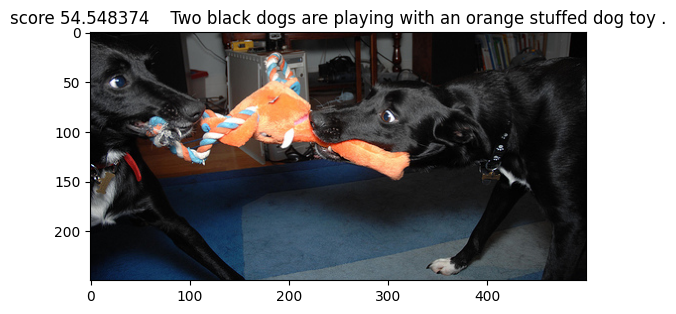

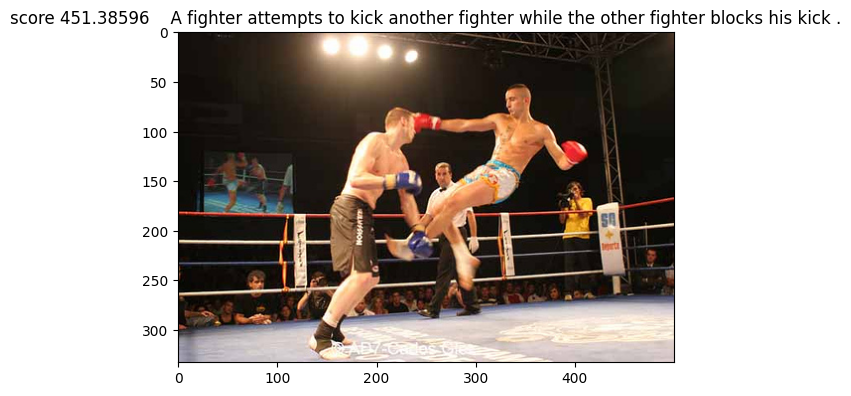

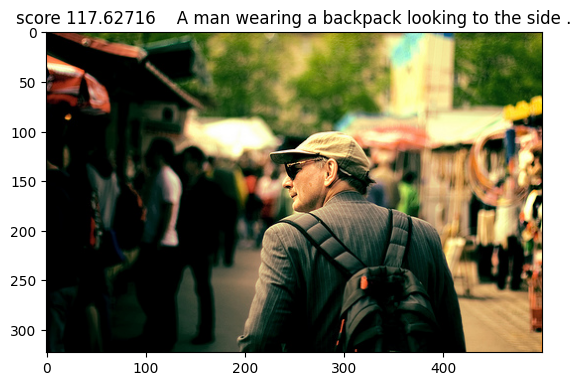

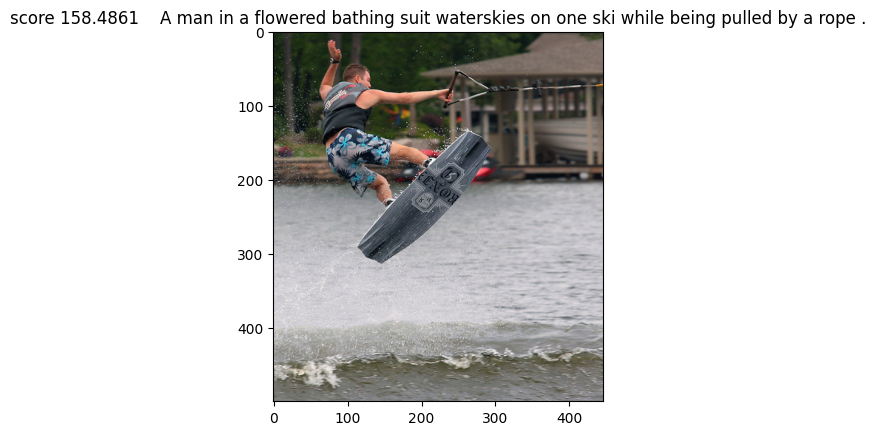

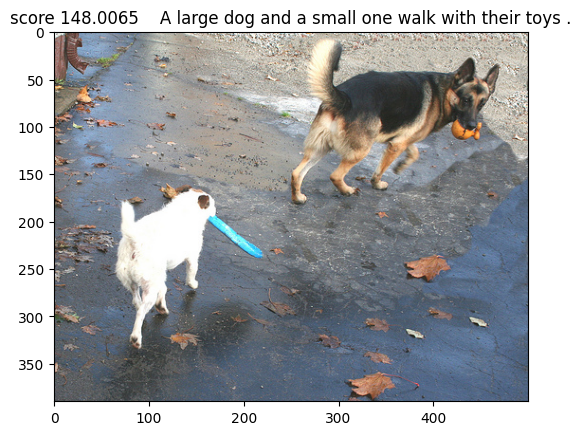

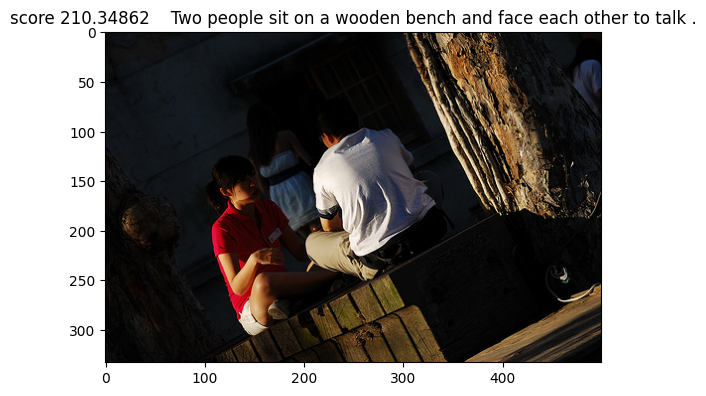

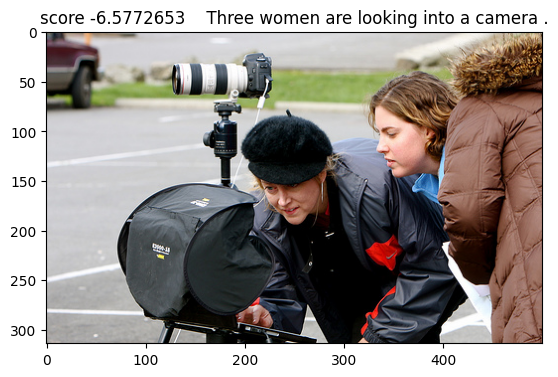

Not avaliable


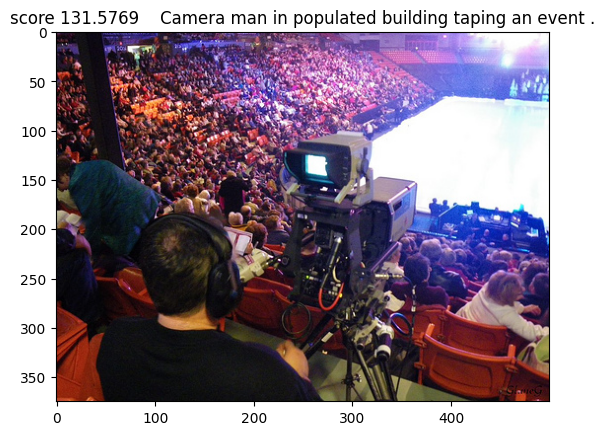

Not avaliable


In [60]:
for i in images:
    if i in test_queries_bad_id.values:
        print('Not avaliable')
    else:
        img=cv2.imread('./test_images/' + i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.imshow(img)
        rt = test_queries[test_queries['query_id0'] == i].sort_values('pred', ascending=False).iloc[0]
        
        # print(rt.)
        plt.title('score ' + str(rt['pred']) + '    ' + rt['query_text'])
        plt.show()

Честно говоря, мне очень нравится как работает обученная модель. Изображение соответствует описанию.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска